Requirements: The folder in question must contain 1 resonance curve and the rest of the files must be lock-in measurement data in the standard Jhe Lab raw data format

Dohyun's experiments were performed at a frequency w != w0 //
The used driving frequencies were those corresponding to the maximum of the resonance curve measurement

In [1]:
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, vectorize, float64

In [2]:
## 0. Define subfunctions for the analysis ##
    
# Resonance curve function
@vectorize("float64(float64, float64, float64, float64, float64)", nopython = True)
def _ResCurve(w, w0, Q, I_0, C0_C):
    W = w/w0
    return (I_0*W/Q)*np.sqrt(np.divide(1+2*C0_C*(1-W**2)+(C0_C*(1-W**2))**2+(C0_C*W/Q)**2, (1-W**2)**2+(W/Q)**2))

# Calibrate electrical phase by converting into radian, then adding the phase offset
@vectorize("float64(float64, float64, float64, float64, float64, float64)", nopython = True)
def _CalibratePhase(Pe, Pe_max, w, w0, Q, C0_C):
    Pe = (Pe - Pe_max)*np.pi/10
    W = w/w0
    Pe_0 = np.arctan2(1-W**2+C0_C*(1-W**2)**2+C0_C*(W/Q)**2, W/Q)
    
    return Pe+Pe_0
    
# Functions to compute physical quantities
@vectorize("float64(float64, float64, float64, float64, float64, float64, float64)", nopython = True)
def _MechAmp(Ae, Pe, w, w0, Q, C0_C, I0): # Takes numpy array Ae and Pe, then returns the mechanical amplitude Am
    Am = np.sqrt(Ae**2-2*w*C0_C*I0*Ae*np.sin(Pe)/(Q*w0)+(w*C0_C*I0/(Q*w0))**2)
    return Am

@vectorize("float64(float64, float64, float64, float64, float64, float64, float64)", nopython = True)
def _MechPhas(Ae, Pe, w, w0, Q, C0_C, I0): # Takes numpy array Ae and Pe, then returns the mechanical phase Pm
    Pm = np.arctan2(Ae*np.sin(Pe)-w*C0_C*I0/(w0*Q), Ae*np.cos(Pe))
    return Pm

@vectorize("float64(float64, float64, float64, float64, float64)", nopython = True)
def _kint(Am, Pm, w, w0, Q): # Takes numpy array Ae and Pe, then returns k_int normalized by k
    kint = np.sin(Pm)/(Am*Q) + (w/w0)**2 - 1
    return kint

@vectorize("float64(float64, float64, float64, float64, float64)", nopython = True)
def _bint(Am, Pm, w, w0, Q): # Takes numpy array Ae and Pe, then returns b_int normalized by k
    bint = (np.cos(Pm)/(Am*w) - (1/w0))/Q
    return bint

@vectorize("float64(float64, float64, float64, float64, float64)", nopython = True)
def _Edis(Am, Pm, w, w0, Q): # Takes numpy array Ae and Pe, then returns E_dis normalized by kA0^2
    Edis = (np.pi/Q)*(Am*np.cos(Pm)-(w/w0)*Am**2)
    return Edis

In [3]:
'''
** DataReformatter(filepath, savepath) **
Inputs:
- folderpath: path to the folder containing the AFM raw data. Each data run in the folder must be organized into subfolders, 
with one resonance curve and multiple approach curves per subfolder

- savepath: path to save the reformatted file, which is in the npz format

Outputs:
- total_dataset: the reformatted AFM dataset in numpy dictionary .npz format
'''
def DataReformatter(folderpath, savepath):
        
    ## 1. initialize dataset arrays ##
    
    filename_dataset = [] # filename
    
    raw_dataset = [] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
    mech_dataset = [] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format

    imin_dataset = [] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

    # Resonance curve fitting parameters
    Q_dataset = []
    w0_dataset = []
    w_dataset = [] # Driving frequency used in the experiment
    I0_dataset = []
    C0C_dataset = []

    E_dataset = [] # Dissipated energy, normalized by kA0^2
    kint_dataset = [] # k_int, normalized by k
    bint_dataset = [] # b_int, normalized by k

    Fk_dataset = [] # <F_k> = kA, normalized by kA0
    Fb_dataset = [] # <F_b> = bwA, normalized by kA0

    
    ## 2. Parse each subfolder and identify the resonance curve ##
    subfolder = os.listdir(folderpath)
    
    for sf in subfolder:
        files = os.listdir(folderpath+'\\'+sf)
    
        # Isolate the resonance curve file from the approach curve files
        i = 0
        while i < len(files):
            if 'res' in files[i]:
                res_file = files.pop(i)
            else:
                i += 1
            
        # Extract Q and w0 from the resonance curve file
        Q = None
        w0 = None
        w = None # Driving frequency used in the experiment
        I_0 = None
        C0_C = None
    
        res_file_path = folderpath+'\\'+sf+'\\'+res_file
        res_data = pd.read_csv(res_file_path, header = None, delimiter = '\t', skiprows = 9)
        res_data = res_data.values
    
        w0_init = res_data[res_data[:,1].argmax(),0] # Frequency of  the maximum amplitude measured. This is the driving frequency used
        w = w0_init

        popt, pcov = curve_fit(_ResCurve, res_data[:,0], res_data[:,1], p0 = [w0_init, 5000, 3, 1/800], bounds = (0, np.inf))
        [w0, Q, I_0, C0_C] = popt
    
        # Parse datafiles in the subfolder
        for i, f in enumerate(files):
                    
            filepath = folderpath+'\\'+sf+'\\'+f
            filename_dataset.append(sf+'-'+f)
        
            Q_dataset.append(Q)
            w0_dataset.append(w0)
            w_dataset.append(w)
            I0_dataset.append(I_0)
            C0C_dataset.append(C0_C)
        
            raw_data = pd.read_csv(filepath, header = None, delimiter = '\t', engine = 'python', skipfooter = 20) # Skip all the comments at the bottom
            raw_data = raw_data.drop(raw_data.columns[3], axis=1) # Drop the Aux1 measurements

            # Convert pandas dataframe to numpy array
            data = raw_data.values # z = data[:,0], Ae = data[:,1], Pe = data[:,2]

            # Convert phase to radian and offset it
            data[:,2] = _CalibratePhase(data[:,2], np.amax(data[:,2]), w, w0, Q, C0_C)
        
            # Create raw data dataset
            raw_dataset.append(data)
        
            # Find turning point index imin
            imin = np.argmin(data[:,0])
            imin_dataset.append(imin)
        
            # Calculate mechanical amplitude and phase, at frequency w!=w0
            mech_data = np.empty(data.shape) # z = data[:,0], Am = mech_data[:,1], Pm = mech_data[:,2]
            mech_data[:,0] = data[:,0]
            mech_data[:,1] = _MechAmp(data[:,1], data[:,2], w, w0, Q, C0_C, I_0)
            mech_data[:,2] = _MechPhas(data[:,1], data[:,2], w, w0, Q, C0_C, I_0)
         
            mech_dataset.append(mech_data)
        
            mech_data[:,1] = mech_data[:,1]/mech_data[0,1]
        
            # Calculate normalized energy dissipation E
            E = _Edis(mech_data[:,1], mech_data[:,2], w, w0, Q)
            E = E - E[0]
            E_dataset.append(E)
        
            # Calculate normalized kint and bint
            kint = _kint(mech_data[:,1], mech_data[:,2], w, w0, Q)
            kint = kint - kint[0]
            
            bint = _bint(mech_data[:,1], mech_data[:,2], w, w0, Q)
            bint = bint - bint[0]
        
            kint_dataset.append(kint)
            bint_dataset.append(bint)
        
            # Calculate normalized Fk and Fb
            Fk = kint*mech_data[:,1]
            Fb = bint*w*mech_data[:,1]
            Fk_dataset.append(Fk)
            Fb_dataset.append(Fb)

            
    ## Convert the results into numpy arrays ##    
    filename_dataset = np.array(filename_dataset)

    raw_dataset = np.array(raw_dataset)
    mech_dataset = np.array(mech_dataset)

    imin_dataset = np.array(imin_dataset)

    Q_dataset = np.array(Q_dataset)
    w0_dataset = np.array(w0_dataset)
    w_dataset = np.array(w_dataset)
    I0_dataset = np.array(I0_dataset)
    C0C_dataset = np.array(C0C_dataset)

    E_dataset = np.array(E_dataset)

    kint_dataset = np.array(kint_dataset)
    bint_dataset = np.array(bint_dataset)

    Fk_dataset = np.array(Fk_dataset)
    Fb_dataset = np.array(Fb_dataset)

    ## Arrange all data into dictionary format for saving ##

    total_dataset = dict([('filename', filename_dataset), ('raw', raw_dataset), ('mech', mech_dataset), ('imin', imin_dataset), ('Q', Q_dataset), ('w0', w0_dataset), ('w', w_dataset), ('I0', I0_dataset), ('C0C', C0C_dataset), ('E', E_dataset), ('kint', kint_dataset), ('bint', bint_dataset), ('Fk', Fk_dataset), ('Fb', Fb_dataset)])
    np.savez(savepath, **total_dataset)

    print('Saved data to: {}'.format(savepath))             
    
    return total_dataset

In [5]:
from scipy.signal import savgol_filter
'''
** DataReformatter2(filepath, savepath) **
Inputs:
- folderpath: path to the folder containing the AFM raw data. Each data run in the folder must be organized into subfolders, 
with one resonance curve and multiple approach curves per subfolder

- savepath: path to save the reformatted file, which is in the npz format

- n_deriv: maximum order of the derivatives(with respect to z) of amplitude and phase to compute

- savgol_param: parameters for the savgol_filter used in the differentiation. In the format of [window_size, poly_order].

Outputs:
- total_dataset: the reformatted AFM dataset in numpy dictionary .npz format
'''
def DataReformatter2(folderpath, savepath, n_deriv = 1, savgol_param = [11, 2]):
        
    ## 1. initialize dataset arrays ##
    
    filename_dataset = [] # filename
    
    raw_dataset = [] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
    mech_dataset = [] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format

    imin_dataset = [] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

    # Resonance curve fitting parameters
    Q_dataset = []
    w0_dataset = []
    w_dataset = [] # Driving frequency used in the experiment
    I0_dataset = []
    C0C_dataset = []

    E_dataset = [] # Dissipated energy, normalized by kA0^2
    kint_dataset = [] # k_int, normalized by k
    bint_dataset = [] # b_int, normalized by k

    Fk_dataset = [] # <F_k> = kA, normalized by kA0
    Fb_dataset = [] # <F_b> = bwA, normalized by kA0

    
    ## 2. Parse each subfolder and identify the resonance curve ##
    subfolder = os.listdir(folderpath)
    
    for sf in subfolder:
        files = os.listdir(folderpath+'/'+sf)
    
        # Isolate the resonance curve file from the approach curve files
        i = 0
        while i < len(files):
            if 'res' in files[i]:
                res_file = files.pop(i)
            else:
                i += 1
            
        # Extract Q and w0 from the resonance curve file
        Q = None
        w0 = None
        w = None # Driving frequency used in the experiment
        I_0 = None
        C0_C = None
    
        res_file_path = folderpath+'/'+sf+'/'+res_file
        res_data = pd.read_csv(res_file_path, header = None, delimiter = '\t', skiprows = 9)
        res_data = res_data.values
    
        w0_init = res_data[res_data[:,1].argmax(),0] # Frequency of  the maximum amplitude measured. This is the driving frequency used
        w = w0_init

        popt, pcov = curve_fit(_ResCurve, res_data[:,0], res_data[:,1], p0 = [w0_init, 5000, 3, 1/800], bounds = (0, np.inf))
        [w0, Q, I_0, C0_C] = popt
    
        # Parse datafiles in the subfolder
        for i, f in enumerate(files):
                    
            filepath = folderpath+'/'+sf+'/'+f
            filename_dataset.append(sf+'-'+f)
        
            Q_dataset.append(Q)
            w0_dataset.append(w0)
            w_dataset.append(w)
            I0_dataset.append(I_0)
            C0C_dataset.append(C0_C)
        
            raw_data = pd.read_csv(filepath, header = None, delimiter = '\t', engine = 'python', skipfooter = 20) # Skip all the comments at the bottom
            raw_data = raw_data.drop(raw_data.columns[3], axis=1) # Drop the Aux1 measurements

            # Convert pandas dataframe to numpy array
            data = raw_data.values # z = data[:,0], Ae = data[:,1], Pe = data[:,2]

            # Convert phase to radian and offset it
            data[:,2] = _CalibratePhase(data[:,2], np.amax(data[:,2]), w, w0, Q, C0_C)
        
            # Create raw data dataset
            raw_dataset.append(data)
        
            # Find turning point index imin
            imin = np.argmin(data[:,0])
            imin_dataset.append(imin)
        
            # Calculate mechanical amplitude and phase, at frequency w!=w0
            row, col = data.shape
            mech_data = np.empty((row, col+2*n_deriv)) # z = data[:,0], Am = mech_data[:,1], Pm = mech_data[:,2]
            mech_data[:,0] = data[:,0]
            mech_data[:,1] = _MechAmp(data[:,1], data[:,2], w, w0, Q, C0_C, I_0)
            mech_data[:,2] = _MechPhas(data[:,1], data[:,2], w, w0, Q, C0_C, I_0)
            
            window_size, poly_order = savgol_param # parameters for the savgol_filter
            for i in range(1, n_deriv+1):
                mech_data[:,1+2*i] = savgol_filter(mech_data[:,1], window_size, poly_order, deriv = i)# d^iA/dz^i
                mech_data[:,2+2*i] = savgol_filter(mech_data[:,2], window_size, poly_order, deriv = i)# d^iPhas/dz^i

            mech_dataset.append(mech_data)
            
            # Normalize mechanical amplitude
            mech_data[:,1] = mech_data[:,1]/mech_data[0,1]
        
            # Calculate normalized energy dissipation E
            E = _Edis(mech_data[:,1], mech_data[:,2], w, w0, Q)
            E = E - E[0]
            E_dataset.append(E)
        
            # Calculate normalized kint and bint
            kint = _kint(mech_data[:,1], mech_data[:,2], w, w0, Q)
            kint = kint - kint[0]
            
            bint = _bint(mech_data[:,1], mech_data[:,2], w, w0, Q)
            bint = bint - bint[0]
        
            kint_dataset.append(kint)
            bint_dataset.append(bint)
        
            # Calculate normalized Fk and Fb
            Fk = kint*mech_data[:,1]
            Fb = bint*w*mech_data[:,1]
            Fk_dataset.append(Fk)
            Fb_dataset.append(Fb)

            
    ## Convert the results into numpy arrays ##    
    filename_dataset = np.array(filename_dataset)

    raw_dataset = np.array(raw_dataset)
    mech_dataset = np.array(mech_dataset)

    imin_dataset = np.array(imin_dataset)

    Q_dataset = np.array(Q_dataset)
    w0_dataset = np.array(w0_dataset)
    w_dataset = np.array(w_dataset)
    I0_dataset = np.array(I0_dataset)
    C0C_dataset = np.array(C0C_dataset)

    E_dataset = np.array(E_dataset)

    kint_dataset = np.array(kint_dataset)
    bint_dataset = np.array(bint_dataset)

    Fk_dataset = np.array(Fk_dataset)
    Fb_dataset = np.array(Fb_dataset)

    ## Arrange all data into dictionary format for saving ##

    total_dataset = dict([('filename', filename_dataset), ('raw', raw_dataset), ('mech', mech_dataset), ('imin', imin_dataset), ('Q', Q_dataset), ('w0', w0_dataset), ('w', w_dataset), ('I0', I0_dataset), ('C0C', C0C_dataset), ('E', E_dataset), ('kint', kint_dataset), ('bint', bint_dataset), ('Fk', Fk_dataset), ('Fb', Fb_dataset)])
    np.savez(savepath, **total_dataset)

    print('Saved data to: {}'.format(savepath))             
    
    return total_dataset

In [8]:
%%time
folderpath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Raw_Data/Shear_Mode/Dohyun_best'
savepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Raw_Data/DohyunBest_deriv2.npz'

total_dataset = DataReformatter2(folderpath, savepath, n_deriv = 2)

Saved data to: /home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Raw_Data/DohyunBest_deriv2.npz
CPU times: user 5.68 s, sys: 99 ms, total: 5.78 s
Wall time: 1.54 s


Example of how to import use the saved .npz format

In [9]:
# Load saved file

# filepath to the reformatted data file
filepath = 'C:\\Users\\user\\OneDrive - SNU\\Jhe Lab\\Projects\\Current\\1. AFM Contact Point Detection\\DohyunBest_final.npz'
savepath = 'C:\\Users\\user\\OneDrive - SNU\\Jhe Lab\\Projects\\Current\\1. AFM Contact Point Detection\\DohyunBest_final.npz'


# load the npz file
dataset = np.load(filepath)
dataset.files

['filename',
 'raw',
 'mech',
 'imin',
 'Q',
 'w0',
 'w',
 'I0',
 'C0C',
 'E',
 'kint',
 'bint',
 'Fk',
 'Fb']

In [10]:
raw_dataset = dataset['raw'] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
mech_dataset = dataset['mech'] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format

imin_dataset = dataset['imin'] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

# Resonance curve fitting parameters
Q_dataset = dataset['Q']
w0_dataset = dataset['w0']
I0_dataset = dataset['I0']
C0C_dataset = dataset['C0C']

E_dataset = dataset['E'] # Dissipated energy, normalized by kA0^2
kint_dataset = dataset['kint'] # k_int, normalized by k
bint_dataset = dataset['bint'] # b_int, normalized by k

Fk_dataset = dataset['Fk'] # <F_k> = kA, normalized by kA0
Fb_dataset = dataset['Fb'] # <F_b> = bwA, normalized by kA0

filename_dataset = dataset['filename'] # filename


In [11]:
n = 10 # trial number
raw = raw_dataset[n]
mech = mech_dataset[n]

imin = imin_dataset[n]

# Resonance curve fitting parameters
Q = Q_dataset[n]
w0 = w0_dataset[n]
I0 = I0_dataset[n]
C0C = C0C_dataset[n]

E = E_dataset[n]
kint = kint_dataset[n]
bint = bint_dataset[n]

Fk = Fk_dataset[n]
Fb = Fb_dataset[n]

filename = filename_dataset[n]

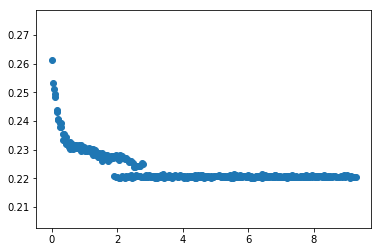

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(mech[:,0], mech[:,2])